# 모델 성능 향상 Practice

> Basic Pytorch CV Classification Practice

Pytorch를 활용한 기초적인 CV 분류 모델 구성 연습 <br>
Google Colab <br>
Cifar-10

#### Import & Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
from torchvision import transforms, datasets
import torch.nn.init as init
import random 

In [2]:
# Device Setting

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version: ', torch.__version__, 'DEVICE:', DEVICE)

# random seed setting
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(777)

Using PyTorch version:  1.8.0+cu101 DEVICE: cuda


#### Data

In [3]:
BATCH_SIZE = 32
EPOCHS = 10
Learning_Rate = 0.01
drop_prob = 0.5 

In [4]:
train_set = torchvision.datasets.CIFAR10(root='./cifar10',
                                        train=True, 
                                        download=True, 
                                        transform = transforms.ToTensor())

test_set = torchvision.datasets.CIFAR10(root='./cifar10', 
                                       train=False, 
                                       download=True, 
                                       transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
    
print('\n')
print('train_set:', train_set)
print('\n')
print('test_set:', test_set)

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


train_set: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train
    StandardTransform
Transform: ToTensor()


test_set: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: ToTensor()


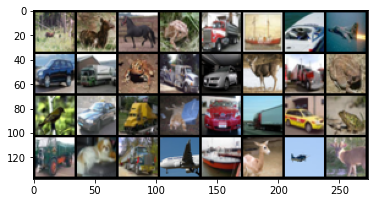

 deer  deer horse  frog


In [6]:
def imshow(img):  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
                    nn.Linear(3 * 32 * 32, 512),
                    nn.Sigmoid())
        
        self.layer2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.Sigmoid())
        
        self.layer3 = nn.Sequential(
                    nn.Linear(256, 10),
                    nn.LogSoftmax(dim = 1))
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32 )
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [ ]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = Learning_Rate)  
criterion = nn.CrossEntropyLoss()  

print(model)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Sigmoid()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


#### Train / Test

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, label)
    
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
 

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): 
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.297429
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.317153
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.306011
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.308355
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.307227
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.316731
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.293787
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.326524

[EPOCH: 1], 	Test Loss: 0.0717, 	Test Accuracy: 13.73 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.296718
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.300159
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.272676
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.269835
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.274272
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.310213
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.266124
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.272570

[EPOCH: 2], 	Test Loss: 0.0707, 	Test Accuracy: 13.45 % 

KeyboardInterrupt: ignored

#### Improve Model Acc

In [17]:
BATCH_SIZE = 64
EPOCHS = 58
Learning_Rate = 0.001
alpha = 0.01
drop_prob = 0.5

# Build Model - Hiddenlayer 2개, BatchNorm, LeakyRelu, Dropout추가 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
                    nn.Linear(3 * 32 * 32, 2048),
                    nn.BatchNorm1d(2048),
                    nn.LeakyReLU(alpha),
                    nn.Dropout(p = drop_prob)
                    )
        
        self.layer2 = nn.Sequential(
                    nn.Linear(2048, 1536),
                    nn.BatchNorm1d(1536),
                    nn.LeakyReLU(alpha),
                    nn.Dropout(p = drop_prob)
                    )
        
        self.layer3 = nn.Sequential(
                    nn.Linear(1536, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU(alpha),
                    nn.Dropout(p = drop_prob)
                    )
        
        self.layer4 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.BatchNorm1d(512),
                    nn.LeakyReLU(alpha),
                    nn.Dropout(p = drop_prob)
                    )
        
        self.layer5= nn.Sequential(
                    nn.Linear(512, 256),
                    nn.BatchNorm1d(256),
                    nn.LeakyReLU(alpha),
                    nn.Dropout(p = drop_prob)
                    )
        
        self.layer6 = nn.Sequential(
                    nn.Linear(256, 10),
                    nn.LogSoftmax(dim = 1))
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32 )
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [18]:
def weight_init(m):
    if isinstance(m, nn.Linear):                         
        init.kaiming_uniform_(m.weight.data) 

model_al = Net().to(DEVICE)
model_al.apply(weight_init)                                                
optimizer = torch.optim.Adam(model_al.parameters(), lr = Learning_Rate)    
criterion = nn.CrossEntropyLoss()                                           

print(model_al)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=2048, out_features=1536, bias=True)
    (1): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=1536, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slop

In [19]:
def train(model, train_loader, optimizer, log_interval):
    model.train()             
    train_loss = 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
            
    train_loss /= batch_idx
    return train_loss

In [20]:
def evaluate(model, test_loader):
    model.eval()                     
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): 
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [21]:
train_loss_item_al = []
test_loss_item_al = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model_al, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model_al, test_loader)
    train_loss_item_al.append(train_loss)
    test_loss_item_al.append(test_loss)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.994865
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.268595
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.069736
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.973065
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.933312
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.875662
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.724438
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.694518

[EPOCH: 1], 	Test Loss: 0.0522, 	Test Accuracy: 39.90 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.748306
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.357568
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.679773
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.001704
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.851177
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.645238
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.544765
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.447620

[EPOCH: 2], 	Test Loss: 0.0480, 	Test Accuracy: 45.93 % 